# End-to-End FINN Flow for the VGG-like 1-Channel Convolutional Net
-----------------------------------------------------------------

We will use the helper function `showInNetron` to show the ONNX model at the current transformation step. The Netron displays are interactive, but they only work when running the notebook actively and not on GitHub (i.e. if you are viewing this on GitHub you'll only see blank squares).

In [1]:
from finn.util.basic import make_build_dir
from finn.util.visualization import showInNetron
    
build_dir = "/workspace/finn"

## 1. FINN Import and Tidy-Up

We will start by importing ONNX of the trained CNN network into FINN and running the "tidy-up" transformations to have a first look at the topology.

In [2]:
import onnx
import brevitas.onnx as bo
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs

model = ModelWrapper(build_dir + "/vgg_gray.onnx")
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(RemoveStaticGraphInputs())
model.save(build_dir + "/vgg_gray_tidy.onnx")

Now that the model is exported, let's have a look at its layer structure with Netron. Remember that the visualization below is interactive, you can click on the individual nodes and view the layer attributes, trained weights and so on.

In [3]:
showInNetron(build_dir+"/vgg_gray_tidy.onnx")

Serving '/workspace/finn/vgg_gray_tidy.onnx' at http://0.0.0.0:8081


You can see that the network is composed of a repeating convolution-maxpool layer pattern to extract features using 3x3 convolution kernels (with weights quantized) and activations, followed by a fully connected layer acting as the classifier. Also notice the initial `MultiThreshold` layer at the beginning of the network, which is quantizing float inputs to 8-bit ones.

### Adding Pre- and Postprocessing <a id='prepost'></a>

Preprocessing and postprocessing steps can be added directly in the ONNX graph. In this case, the preprocessing step divides the input `uint8` data by 255 so the inputs to the CNN network are bounded between [0, 1]. The postprocessing step takes the output of the network and returns the index (0-9) of the image category with the highest probability (top-1). 

In [4]:
from finn.util.pytorch import ToTensor
from finn.transformation.merge_onnx_models import MergeONNXModels
from finn.core.datatype import DataType

model = ModelWrapper(build_dir+"/vgg_gray_tidy.onnx")
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = build_dir+"/vgg_gray_preproc.onnx"
bo.export_finn_onnx(totensor_pyt, ishape, chkpt_preproc_name)

# join preprocessing and core model
pre_model = ModelWrapper(chkpt_preproc_name)
model = model.transform(MergeONNXModels(pre_model))
# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])

/workspace/finn-base/src/finn/transformation/infer_data_layouts.py:119: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


In [5]:
from finn.transformation.insert_topk import InsertTopK
from finn.transformation.infer_datatypes import InferDataTypes

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = build_dir+"/vgg_gray_pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

In [6]:
showInNetron(build_dir+"/vgg_gray_pre_post.onnx")

Stopping http://0.0.0.0:8081
Serving '/workspace/finn/vgg_gray_pre_post.onnx' at http://0.0.0.0:8081


## 2. How FINN Implements Convolutions: Lowering and Streamlining

In FINN, we implement convolutions with the *lowering* approach: we convert them to matrix-matrix multiply operations, where one of the matrices is generated by sliding a window over the input image. You can read more about the sliding window operator and how convolution lowering works [in this notebook](https://github.com/maltanar/qnn-inference-examples/blob/master/3-convolutional-binarized-gtsrb.ipynb). The streaming dataflow architecture we will end up with is going to look something like this figure from the [FINN-R paper](https://arxiv.org/abs/1809.04570).

Note how the convolution layer looks very similar to the fully connected one in terms of the matrix-vector-threshold unit (MVTU), but now the MVTU is preceded by a sliding window unit that produces the matrix from the input image. All of these building blocks, including the `MaxPool` layer you see in this figure, exist as templated Vivado HLS C++ functions in [finn-hlslib](https://github.com/Xilinx/finn-hlslib).


To target this kind of hardware architecture with our network we'll apply a convolution lowering transformation, in addition to streamlining. You may recall the *streamlining transformation* that we applied to the TFC-w1a1 network, which is a series of mathematical simplifications that allow us to get rid of floating point scaling operations by implementing few-bit activations as thresholding operations. **The current implementation of streamlining is highly network-specific and may not work for your network if its topology is very different than the example network here. We hope to rectify this in future releases.**

In [7]:
from finn.transformation.streamline import Streamline
from finn.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from finn.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants
from finn.transformation.infer_data_layouts import InferDataLayouts
from finn.transformation.general import RemoveUnusedTensors

model = ModelWrapper(build_dir + "/vgg_gray_pre_post.onnx")
model = model.transform(MoveScalarLinearPastInvariants())
model = model.transform(Streamline())
model = model.transform(LowerConvsToMatMul())
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())
model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(Streamline())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())
model.save(build_dir + "/vgg_gray_streamlined.onnx")

We won't go into too much detail about what happens in each transformation and why they are called in the particular order they are (feel free to visualize the intermediate steps using Netron yourself if you are curious) but here is a brief summmmary:

* `Streamline` moves floating point scaling and addition operations closer to the input of the nearest thresholding activation and absorbs them into thresholds
* `LowerConvsToMatMul` converts ONNX `Conv` nodes into sequences of `Im2Col, MatMul` nodes as discussed above. `Im2Col` is a custom FINN ONNX high-level node type that implements the sliding window operator.
* `MakeMaxPoolNHWC` and `AbsorbTransposeIntoMultiThreshold` convert the *data layout* of the network into the NHWC data layout that finn-hlslib primitives use. NCHW means the tensor dimensions are ordered as `(N : batch, H : height, W : width, C : channels)` (assuming 2D images). The ONNX standard ops normally use the NCHW layout, but the ONNX intermediate representation itself does not dictate any data layout.
* You may recall `ConvertBipolarMatMulToXnorPopcount` from the TFC-w1a1 example, which is needed to implement bipolar-by-bipolar (w1a1) networks correctly using finn-hlslib.

Let's visualize the streamlined and lowered network with Netron. Observe how all the `Conv` nodes have turned into pairs of `Im2Col, MatMul` nodes, and many nodes including `BatchNorm, Mul, Add` nodes have disappeared and replaced with `MultiThreshold` nodes.

In [8]:
showInNetron(build_dir+"/vgg_gray_streamlined.onnx")

Stopping http://0.0.0.0:8081
Serving '/workspace/finn/vgg_gray_streamlined.onnx' at http://0.0.0.0:8081


## 3. Partitioning, Conversion to HLS Layers and Folding

The next steps will be (again) very similar to what we did for the TFC-w1a1 network. We'll first convert the layers that we can put into the FPGA into their HLS equivalents and separate them out into a *dataflow partition*:


In [9]:
import finn.transformation.fpgadataflow.convert_to_hls_layers as to_hls
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
from finn.transformation.move_reshape import RemoveCNVtoFCFlatten
from finn.custom_op.registry import getCustomOp
from finn.transformation.infer_data_layouts import InferDataLayouts

# choose the memory mode for the MVTU units, decoupled or const
mem_mode = "decoupled"

model = ModelWrapper(build_dir + "/vgg_gray_streamlined.onnx")
model = model.transform(to_hls.InferBinaryStreamingFCLayer(mem_mode))
model = model.transform(to_hls.InferQuantizedStreamingFCLayer(mem_mode))
# TopK to LabelSelect
model = model.transform(to_hls.InferLabelSelectLayer())
# input quantization (if any) to standalone thresholding
model = model.transform(to_hls.InferThresholdingLayer())
model = model.transform(to_hls.InferConvInpGen())
model = model.transform(to_hls.InferStreamingMaxPool())
# get rid of Reshape(-1, 1) operation between hlslib nodes
model = model.transform(RemoveCNVtoFCFlatten())
# get rid of Tranpose -> Tranpose identity seq
model = model.transform(absorb.AbsorbConsecutiveTransposes())
# infer tensor data layouts
model = model.transform(InferDataLayouts())
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(build_dir + "/vgg_gray_dataflow_parent.onnx")
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
# save the dataflow partition with a different name for easier access
dataflow_model = ModelWrapper(dataflow_model_filename)
dataflow_model.save(build_dir + "/vgg_gray_dataflow_model.onnx")

/workspace/finn/src/finn/custom_op/fpgadataflow/streamingfclayer_batch.py:591: UserWarning: Clipping some thresholds in StreamingFCLayer_Batch_MatMul_0
  warnings.warn("Clipping some thresholds in %s" % self.onnx_node.name)
/workspace/finn/src/finn/custom_op/fpgadataflow/streamingfclayer_batch.py:591: UserWarning: Clipping some thresholds in StreamingFCLayer_Batch_MatMul_2
  warnings.warn("Clipping some thresholds in %s" % self.onnx_node.name)


Notice the additional `RemoveCNVtoFCFlatten` transformation that was not used for TFC-w1a1. In the last Netron visualization you may have noticed a `Reshape` operation towards the end of the network where the convolutional part of the network ends and the fully-connected layers started. That `Reshape` is essentialy a tensor flattening operation, which we can remove for the purposes of hardware implementation. We can examine the contents of the dataflow partition with Netron, and observe the `ConvolutionInputGenerator`, `StreamingFCLayer_Batch` and `StreamingMaxPool_Batch` nodes that implement the sliding window, matrix multiply and maxpool operations in hlslib. *Note that the StreamingFCLayer instances following the ConvolutionInputGenerator nodes are really implementing the convolutions, despite the name. The final StreamingFCLayer instance implement an actual FC layer.*

In [10]:
showInNetron(build_dir + "/vgg_gray_dataflow_parent.onnx")

Stopping http://0.0.0.0:8081
Serving '/workspace/finn/vgg_gray_dataflow_parent.onnx' at http://0.0.0.0:8081


Note that pretty much everything has gone into the `StreamingDataflowPartition` node; the only operation remaining is to apply a `Transpose` to obtain NHWC input from a NCHW input (the ONNX default). 

In [11]:
showInNetron(build_dir + "/vgg_gray_dataflow_model.onnx")

Stopping http://0.0.0.0:8081
Serving '/workspace/finn/vgg_gray_dataflow_model.onnx' at http://0.0.0.0:8081


Now we have to set the *folding factors* for certain layers to adjust the performance of our accelerator, similar to the TFC-w1a1 example. We'll also set the desired FIFO depths around those layers, which are important to achieve full throughput in the accelerator.

In [12]:
model = ModelWrapper(build_dir + "/vgg_gray_dataflow_model.onnx")
fc_layers = model.get_nodes_by_op_type("StreamingFCLayer_Batch")
# each tuple is (PE, SIMD, in_fifo_depth, ramstyle) for a layer
folding = [
    (8, 1, 32, "auto"),
    (8, 16, 32, "distributed"),
    (4, 16, 32, "auto"),
    (1, 16, 32, "auto"),
    (5, 1, 4, "distributed"),
]
for fcl, (pe, simd, ififodepth, ramstyle) in zip(fc_layers, folding):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepth", ififodepth)
    fcl_inst.set_nodeattr("ram_style", ramstyle)

# use same SIMD values for the sliding window operators
swg_layers = model.get_nodes_by_op_type("ConvolutionInputGenerator")
for i in range(len(swg_layers)):
    swg_inst = getCustomOp(swg_layers[i])
    simd = folding[i][1]
    swg_inst.set_nodeattr("SIMD", simd)

model = model.transform(GiveUniqueNodeNames())
model.save(build_dir + "/vgg_gray_folded.onnx")

Below we visualize in Netron to observe the `StreamingDataWidthConverter` and `StreamingFIFO` nodes that have been inserted into graph, as well as the folding factors in the `PE` and `SIMD` attributes of each `StreamingFCLayer_Batch`.

In [13]:
showInNetron(build_dir + "/vgg_gray_folded.onnx")

Stopping http://0.0.0.0:8081
Serving '/workspace/finn/vgg_gray_folded.onnx' at http://0.0.0.0:8081


Our network is now ready and we can start with the hardware generation.

## 4. Hardware Generation

From this point onward, the steps we have to follow do not depend on the particular network and will be exactly the same as the TFC-w1a1 example. **which may take about 30 minutes depending on your host computer**. For more details about what's going on in this step, please consult the [TFC end-to-end notebook](tfc_end2end_example.ipynb) or the appropriate section in the [FINN documentation](https://finn.readthedocs.io/en/latest/hw_build.html).

In [14]:
test_pynq_board = "Pynq-Z2"
target_clk_ns = 10

from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild
model = ModelWrapper(build_dir+"/vgg_gray_folded.onnx")
model = model.transform(ZynqBuild(platform = test_pynq_board, period_ns = target_clk_ns))
model.save(build_dir + "/vgg_gray_synth.onnx")

/workspace/finn/src/finn/transformation/fpgadataflow/floorplan.py:107: UserWarning: 25 nodes have no entry in the provided floorplan, SLR was set to -1
  warnings.warn(
/workspace/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:154: UserWarning: Overriding input FIFO depth to 32
  warnings.warn("Overriding input FIFO depth to 32")
/workspace/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:201: UserWarning: Overriding output FIFO depth to 32
  warnings.warn("Overriding output FIFO depth to 32")


## 5. Deployment and Remote Execution

Now that we're done with the hardware generation, we can generate a Python driver for accelerator and copy the necessary files onto our PYNQ board.

**Make sure you've [set up the SSH keys for your PYNQ board](https://finn-dev.readthedocs.io/en/latest/getting_started.html#pynq-board-first-time-setup) before executing this step.**

In [15]:
import os

# set up the following values according to your own environment
# FINN will use ssh to deploy and run the generated accelerator
ip = os.getenv("PYNQ_IP", "192.168.2.99")
username = os.getenv("PYNQ_USERNAME", "xilinx")
password = os.getenv("PYNQ_PASSWORD", "xilinx")
port = os.getenv("PYNQ_PORT", 22)
target_dir = os.getenv("PYNQ_TARGET_DIR", "/home/xilinx/finn_cnv_end2end_example")
# set up ssh options to only allow publickey authentication
options = "-o PreferredAuthentications=publickey -o PasswordAuthentication=no"

# test access to PYNQ board
! ssh {options} {username}@{ip} -p {port} cat /var/run/motd.dynamic

Welcome to PYNQ Linux, based on Ubuntu 18.04 (GNU/Linux 5.4.0-xilinx-v2020.1 armv7l)

 * Super-optimized for small spaces - read how we shrank the memory
   footprint of MicroK8s to make it the smallest full K8s around.

   https://ubuntu.com/blog/microk8s-memory-optimisation


In [16]:
from finn.transformation.fpgadataflow.make_deployment import DeployToPYNQ
from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver

model = ModelWrapper(build_dir + "/vgg_gray_synth.onnx")
model = model.transform(MakePYNQDriver(platform="zynq-iodma"))
model = model.transform(DeployToPYNQ(ip, port, username, password, target_dir))
model.save(build_dir + "/vgg_gray_pynq_deploy.onnx")

In [17]:
target_dir_pynq = target_dir + "/" + model.get_metadata_prop("pynq_deployment_dir").split("/")[-1]
target_dir_pynq

'/home/xilinx/finn_dev_owner/pynq_deployment_njsd47ii'

In [18]:
! ssh {options} {username}@{ip} -p {port} 'ls -l {target_dir_pynq}'

total 4244
-rw-rw-r-- 1 xilinx xilinx   20556 Jan 22 21:34 driver_base.py
-rw-r--r-- 1 xilinx xilinx    5031 Jan 22 21:34 driver.py
drwxr-xr-x 4 xilinx xilinx    4096 Jan 22 21:34 finn
-rw-r--r-- 1 xilinx xilinx 4045671 Jan 22 21:34 resizer.bit
-rw-r--r-- 1 xilinx xilinx  246855 Jan 22 21:34 resizer.hwh
drwxr-xr-x 2 xilinx xilinx    4096 Jan 22 21:34 runtime_weights
-rw-rw-r-- 1 xilinx xilinx    4113 Jan 22 21:34 validate.py


We only have two more steps to be able to remotely execute the deployed bitfile with some test data from the CIFAR-10 dataset. Let's load up some test data that comes bundled with FINN -- *and before you ask, that's supposed to be a cat (CIFAR-10 class number 3)*.

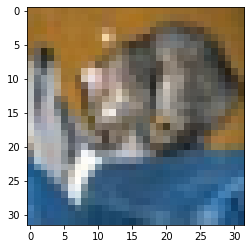

In [19]:
import pkg_resources as pk
import matplotlib.pyplot as plt
import numpy as np

fn = pk.resource_filename("finn.qnn-data", "cifar10/cifar10-test-data-class3.npz")
x = np.load(fn)["arr_0"]
x = x.reshape(3, 32, 32).transpose(1, 2, 0)
plt.imshow(x)

Recall that we partitioned our original network into a parent graph that contained the non-synthesizable nodes and a child graph that contained the bulk of the network, which we turned into a bitfile. The only operator left outside the FPGA partition was a `Transpose` to convert NCHW images into NHWC ones. Thus, we can skip the execution in the parent as long as we ensure our image has the expected data layout, which we have done above.

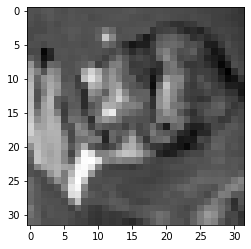

In [20]:
B, G, R = x.transpose(2, 0, 1).astype("uint32")
xx = ((B*3735+G*19235+R*9798)//(2**15)).reshape((32, 32, 1)).astype("uint8")
plt.imshow(xx, cmap="gray")

In [21]:
import numpy as np
from finn.core.onnx_exec import execute_onnx

model = ModelWrapper(build_dir + "/vgg_gray_pynq_deploy.onnx")
iname = model.graph.input[0].name
oname = model.graph.output[0].name
ishape = model.get_tensor_shape(iname)
input_dict = {iname: xx.astype(np.float32).reshape(ishape)}
ret = execute_onnx(model, input_dict, True)

In [22]:
ret[oname]

array([[3.]], dtype=float32)

We see that the network correctly predicts this as a class 3 ("cat"). 

### Validating the Accuracy on a PYNQ Board <a id='validation'></a>

All the command line prompts here are meant to be executed with `sudo` on the PYNQ board, so we'll use a workaround (`echo password | sudo -S command`) to get that working from this notebook running on the host computer.

In [23]:
! ssh {options} -t {username}@{ip} -p {port} 'cd {target_dir_pynq}; echo {password} | sudo -S sed -i '"'"'75s/^/\n    B,G,R=testx.transpose(3, 0, 1, 2).astype("uint32");testx=((B*3735+G*19235+R*9798)\/\/(2**15)).reshape(testx.shape[:-1]+(1,)).astype("uint8")/'"'"' validate.py'

[sudo] password for xilinx: Connection to 192.168.2.99 closed.


We can now use the `validate.py` script that was generated together with the driver to measure top-1 accuracy on the CIFAR-10 dataset.

Command to execute on PYNQ:

`python3.6 validate.py --dataset cifar10 --batchsize 1000`

In [24]:
! ssh {options} -t {username}@{ip} -p {port} 'cd {target_dir_pynq}; echo {password} | sudo -S python3.6 validate.py --dataset cifar10 --batchsize 1000'

[sudo] password for xilinx: Downloading Python CIFAR10 Data.
Download URL: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Download DIR: /tmp
>> Downloading cifar-10-python.tar.gz 100.0%
Extracting Python CIFAR10 data.
Files extracted
batch 1 / 10 : total OK 857 NOK 143
batch 2 / 10 : total OK 1695 NOK 305
batch 3 / 10 : total OK 2540 NOK 460
batch 4 / 10 : total OK 3377 NOK 623
batch 5 / 10 : total OK 4233 NOK 767
batch 6 / 10 : total OK 5068 NOK 932
batch 7 / 10 : total OK 5920 NOK 1080
batch 8 / 10 : total OK 6764 NOK 1236
batch 9 / 10 : total OK 7586 NOK 1414
batch 10 / 10 : total OK 8447 NOK 1553
Final accuracy: 84.470000
Connection to 192.168.2.99 closed.


We see that the final top-1 accuracy is 84.47%, which is very close to the 84.22% reported on the [BNN-PYNQ accuracy table in Brevitas](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples/bnn_pynq). 